**Máster Universitario en Ciencia de Datos, UAM**
## **Procesamiento del Lenguaje Natural**
# **Práctica de laboratorio 2: Aprendizaje profundo para análisis de sentimientos**


---



Práctica realizada por Enrique Ernesto De Alvear Doñate y Javier Alarcón Caracena.

# ***Ejercicio 1 - FFNs***

# Carga y preprocesado de datos - One-hot encoding

In [2]:
# Montamos el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Fijamos semillas para generación de números aleatorios
import numpy as np
import tensorflow as tf
import re
import pandas as pd
from tensorflow.keras.preprocessing import text
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import bz2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

np.random.seed(1)
tf.random.set_seed(2)

In [4]:
# Utilizamos el Stanford Sentiment Treebank (SST) como corpus de prueba para análisis de sentimientos de textos
# Cargamos y procesamos los datos para tratarlos como un problema de clasificación binaria de sentimientos
# Convertimos la escala de sentimientos de [1,5] a {0,1}
def load_sst_dataset(file_path, label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(file_path) as f:
        for i, line in enumerate(f):
            instance = {}
            instance['label'] = label_map[int(line[1])]
            if instance['label'] is None:
                continue

            # Filtramos caracteres y etiquetas de parseo
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            instance['text'] = text[1:]
            data.append(instance)
    data = pd.DataFrame(data)
    return data

data_folder = '/content/drive/MyDrive/P2-PLN/data/'
training_set = load_sst_dataset(data_folder + 'sst_training.txt') # conjunto de datos de entrenamiento
validation_set = load_sst_dataset(data_folder + 'sst_validation.txt') # conjunto de datos de validación
test_set = load_sst_dataset(data_folder + 'sst_test.txt') # conjunto de datos de test

print('Instancias de entrenamiento: {}'.format(len(training_set)))
print('Instancias de de validación: {}'.format(len(validation_set)))
print('Instancias de de test: {}'.format(len(test_set)))

Instancias de entrenamiento: 6920
Instancias de de validación: 872
Instancias de de test: 1821


In [5]:
# Desordenamos los conjuntos de datos
training_set = shuffle(training_set)
validation_set = shuffle(validation_set)
test_set = shuffle(test_set)

# Separamos textos y etiquetas de los conjuntos de datos
training_texts = training_set.text
training_labels = training_set.label
validation_texts = validation_set.text
validation_labels = validation_set.label
test_texts = test_set.text
test_labels = test_set.label

# Construimos un índice (vocabulario) para las 1000 palabras más frecuentes en el conjunto de datos de entrenamiento
tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(training_texts)

print("10 palabras del vocabulario con mayor frecuencia:")
words_index = tokenizer.word_index
for word, index in list(words_index.items())[:10]:
    count = tokenizer.word_counts[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")
print()

sorted_word_counts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=False)
last_words_counts = sorted_word_counts[:10]
print("10 palabras del vocabulario con menor frecuencia:")
for word, count in last_words_counts:
    index = tokenizer.word_index[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")

10 palabras del vocabulario con mayor frecuencia:
	the  (índice: 1, frecuencia: 5996)
	a  (índice: 2, frecuencia: 4385)
	and  (índice: 3, frecuencia: 3869)
	of  (índice: 4, frecuencia: 3680)
	to  (índice: 5, frecuencia: 2464)
	is  (índice: 6, frecuencia: 2099)
	's  (índice: 7, frecuencia: 2025)
	it  (índice: 8, frecuencia: 1952)
	that  (índice: 9, frecuencia: 1613)
	in  (índice: 10, frecuencia: 1581)

10 palabras del vocabulario con menor frecuencia:
	aid  (índice: 7198, frecuencia: 1)
	milking  (índice: 7199, frecuencia: 1)
	ken  (índice: 7200, frecuencia: 1)
	vacuous  (índice: 7201, frecuencia: 1)
	embody  (índice: 7202, frecuencia: 1)
	nouvelle  (índice: 7203, frecuencia: 1)
	enact  (índice: 7204, frecuencia: 1)
	chapter  (índice: 7205, frecuencia: 1)
	playwright  (índice: 7206, frecuencia: 1)
	drinker  (índice: 7207, frecuencia: 1)


In [6]:
# Vectorizamos los textos mediante la representación one-hot encoding
x_training = tokenizer.texts_to_matrix(training_texts, mode='binary')
y_training = training_labels
x_validation = tokenizer.texts_to_matrix(validation_texts, mode='binary')
y_validation = validation_labels
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_training.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_validation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

Dimensiones del conjunto de entrenamiento: (6920, 1000)
Dimensiones del conjunto de validación: (872, 1000)
Dimensiones del conjunto de test: (1821, 1000)


In [7]:
# Comprobación de algunos vectores generados:
# Iteramos sobre n textos (de entrenamiento) y sus vectores correspondientes
n = 3

index_to_word = tokenizer.index_word # Mapeos de índices a palabras en el vocabulario
word_counts = tokenizer.word_counts # Frecuencias de las palabras en los textos

for i, (text, text_vector) in enumerate(zip(training_texts[:n], x_training[:n]), start=1):
    print(f"Texto {i}: {text}")
    print(f"Vector: {text_vector}")
    print("Palabras:")
    for index, value in enumerate(text_vector):
        # Si el valor en el vector es 1, obtenemos la palabra correspondiente, junto con su índice y frecuencia en el vocabulario
        if value == 1:
            word = index_to_word.get(index)
            word_frequency = word_counts.get(word, 0) if word else 0
            print(f"\t{word} (índice={index}, frecuencia={word_frequency})")
    print()
input_size = x_training[0].shape[0]

Texto 1: It is dark , brooding and slow , and takes its central idea way too seriously .
Vector: [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Construcción de la red

In [ ]:
input_size = x_training[0].shape[0] # la longitud del vector de entrada es igual al tamaño del vocabulario

# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16033 (62.63 KB)
Trainable params: 16033 (62.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenamos la red durante 100 épocas y con batches de tamaño 32
history = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
217/217 [==============================] - 1s 3ms/step - loss: 0.6444 - accuracy: 0.6324 - val_loss: 0.5671 - val_accuracy: 0.7431
Epoch 2/100
217/217 [==============================] - 0s 2ms/step - loss: 0.5209 - accuracy: 0.7620 - val_loss: 0.5084 - val_accuracy: 0.7615
Epoch 3/100
217/217 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.7909 - val_loss: 0.4986 - val_accuracy: 0.7534
Epoch 4/100
217/217 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.8025 - val_loss: 0.5014 - val_accuracy: 0.7626
Epoch 5/100
217/217 [==============================] - 0s 2ms/step - loss: 0.4141 - accuracy: 0.8101 - val_loss: 0.5057 - val_accuracy: 0.7569
Epoch 6/100
217/217 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8129 - val_loss: 0.5143 - val_accuracy: 0.7603
Epoch 7/100
217/217 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8201 - val_loss: 0.5206 - val_accuracy: 0.7523

**Ejercicio 1a - Red de una capa oculta**

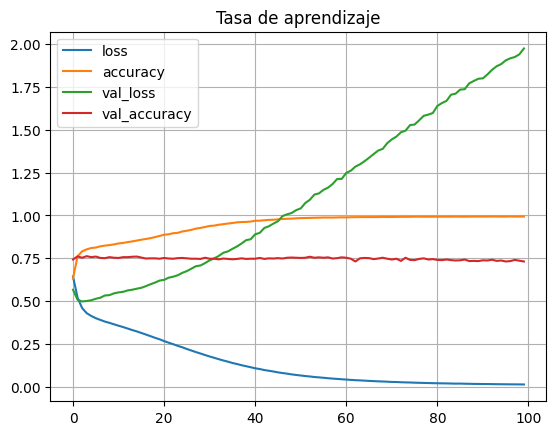

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()
# TO DO

La gráfica generada muestra la evolución de la pérdida de entrenamiento "loss" de color azul,  la fución de pérdida en validación "val_loss" verde, el accuracy del modelo respecto al conjunto de entrenamiento en naranja y el accuracy de validación en rojo.

Se puede ver que ya en los primeros pasos del entrenamiento las dos gráficas de la pérdida se cruzan, creciendo la de validación de forma indefinida y la de entrenamiento bajando a 0, esto muestra un claro ejemplo de overfitting, que nos lo confima las gráficas de accuracy. Ya que el accuracy de entrenamiento tiende a 1 y se ve que en el límite prácticamente lo alcanza mientra que el accuracy de validación se queda estancado en 0.75, por lo tanto realmente el modelo había que parar de entrenarlo bastantes epochs antes.

**Ejercicio 1b - Red multicapa**

In [ ]:
# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=16, activation = 'relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()
# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                16016     
                                                                 
 dense_35 (Dense)            (None, 16)                272       
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
217/217 [==============================] - 2s 5ms/step - loss: 0.2287 - accuracy: 0.6353 - val_loss: 0.1869 - val_accuracy: 0.7328
Epoch 2/100
217/217 [==============================] - 1s 4ms/step - loss: 0.1645 - accuracy: 0.7702 - val_loss: 0.1669 - val_accuracy: 0.7603
Epoch 3/100
217/217 [==============================] - 1s 4ms/step - loss: 0.1376 - accuracy: 0.8069 - val_loss: 0.1671 - val_accuracy: 0.7638
Epoch 4/100
217/217 [==============================] - 1s 3ms/step - loss: 0.1233 - accuracy: 0.8306 - val_loss: 0.1726 - val_accuracy: 0.7569
Epoch 5/100
217/217 [==============================] - 1s 3ms/step - loss: 0.1110 - accuracy: 0.8545 - val_loss: 0.1775 - val_accuracy: 0.7569
Epoch 6/100
217/217 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.8738 - val_loss: 0.1832 - val_accuracy: 0.7511
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.0860 - accuracy: 0.8962 - val_loss: 0.1849 - val_accuracy: 0.7557

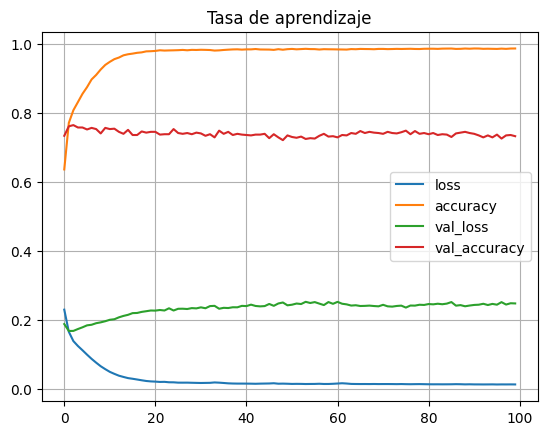

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()


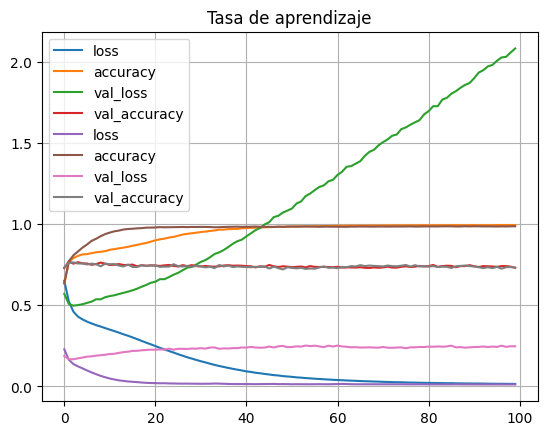

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
pd.DataFrame(history2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Se puede ver que aunque los resultados en accuracy son bastante parecidos, ya que el del conjunto de validación se queuda también estancado en el mismo valor, el accuracy de entrenamiento crece mucho más rápido en este modelo y la función de pérdida empieza en un valor más bajo que la del anterior modelo. Además hay que destacar que la pérdida del conjunto de validación no crece indefinidamente si no que se queda estancada sin superar el 0.3


**Ejercicio 1c - Evitando el sobreajuste: early stopping, weight regularization, dropout**

In [ ]:

# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=16, activation = 'relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
callback = EarlyStopping(monitor='loss', min_delta=.05, mode="min" ,patience=5, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                16016     
                                                                 
 dense_38 (Dense)            (None, 16)                272       
                                                                 
 dense_39 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), callbacks = [callback], verbose=1)

Epoch 1/100
217/217 [==============================] - 2s 3ms/step - loss: 0.6529 - accuracy: 0.6143 - val_loss: 0.5549 - val_accuracy: 0.7431
Epoch 2/100
217/217 [==============================] - 1s 3ms/step - loss: 0.5009 - accuracy: 0.7655 - val_loss: 0.5029 - val_accuracy: 0.7661
Epoch 3/100
217/217 [==============================] - 1s 3ms/step - loss: 0.4271 - accuracy: 0.8025 - val_loss: 0.5108 - val_accuracy: 0.7557
Epoch 4/100
217/217 [==============================] - 1s 3ms/step - loss: 0.3882 - accuracy: 0.8276 - val_loss: 0.5301 - val_accuracy: 0.7489
Epoch 5/100
217/217 [==============================] - 1s 3ms/step - loss: 0.3552 - accuracy: 0.8454 - val_loss: 0.5509 - val_accuracy: 0.7580
Epoch 6/100
217/217 [==============================] - 1s 3ms/step - loss: 0.3192 - accuracy: 0.8605 - val_loss: 0.5723 - val_accuracy: 0.7466
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.2826 - accuracy: 0.8844 - val_loss: 0.6080 - val_accuracy: 0.7580

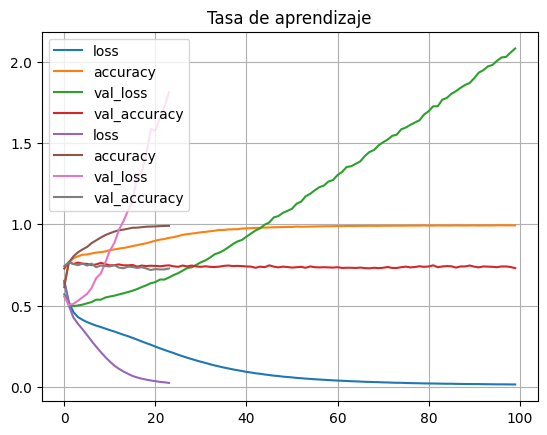

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
pd.DataFrame(history2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Utilizando el EarlyStopping de keras se pude ver que aunque los resultados del modelo son muy parecidos que respecto al modelo normal el entrenamiento se detiene en el epoch 24, que es cuando el accuracy deja de crecer y empieza a estancarse.

In [ ]:
# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu',kernel_regularizer = regularizers.L2(0.001), input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=16, activation = 'relu', kernel_regularizer = regularizers.L2(0.001),))
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)
# TO DO

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                16016     
                                                                 
 dense_41 (Dense)            (None, 16)                272       
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation),  verbose=1)


Epoch 1/100
217/217 [==============================] - 2s 4ms/step - loss: 0.6745 - accuracy: 0.6273 - val_loss: 0.5736 - val_accuracy: 0.7317
Epoch 2/100
217/217 [==============================] - 1s 4ms/step - loss: 0.5361 - accuracy: 0.7684 - val_loss: 0.5418 - val_accuracy: 0.7615
Epoch 3/100
217/217 [==============================] - 1s 4ms/step - loss: 0.4885 - accuracy: 0.7948 - val_loss: 0.5512 - val_accuracy: 0.7592
Epoch 4/100
217/217 [==============================] - 1s 4ms/step - loss: 0.4698 - accuracy: 0.8056 - val_loss: 0.5599 - val_accuracy: 0.7511
Epoch 5/100
217/217 [==============================] - 1s 5ms/step - loss: 0.4572 - accuracy: 0.8136 - val_loss: 0.5710 - val_accuracy: 0.7431
Epoch 6/100
217/217 [==============================] - 1s 3ms/step - loss: 0.4391 - accuracy: 0.8241 - val_loss: 0.5797 - val_accuracy: 0.7523
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.4182 - accuracy: 0.8422 - val_loss: 0.5893 - val_accuracy: 0.7523

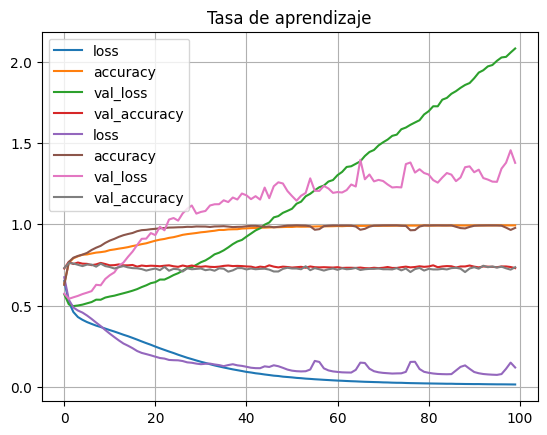

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
pd.DataFrame(history2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Utilizando regularizadores se puede ver ligeros cambios en el comportamiento de las curvas de aprendizaje y de accuracy, se puede ver que el comportamiento de la red en lo que a accuracy se refiere es más o menos el mismo, destacando una subida del loss (y bajada del accuracy) periódicamente cada 5 épocas, y se puede ver que se reduce la tasa de crecimiento del error de validación.

In [ ]:


# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dropout(0.5))
model.add(Dense(units=16, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# TO DO

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 16)                16016     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation),  verbose=1)


Epoch 1/100
217/217 [==============================] - 2s 4ms/step - loss: 0.6925 - accuracy: 0.5275 - val_loss: 0.6761 - val_accuracy: 0.6101
Epoch 2/100
217/217 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.5939 - val_loss: 0.6213 - val_accuracy: 0.7018
Epoch 3/100
217/217 [==============================] - 1s 4ms/step - loss: 0.6117 - accuracy: 0.6741 - val_loss: 0.5544 - val_accuracy: 0.7443
Epoch 4/100
217/217 [==============================] - 1s 4ms/step - loss: 0.5575 - accuracy: 0.7247 - val_loss: 0.5192 - val_accuracy: 0.7672
Epoch 5/100
217/217 [==============================] - 1s 4ms/step - loss: 0.5108 - accuracy: 0.7555 - val_loss: 0.5036 - val_accuracy: 0.7557
Epoch 6/100
217/217 [==============================] - 1s 4ms/step - loss: 0.4822 - accuracy: 0.7824 - val_loss: 0.5035 - val_accuracy: 0.7569
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.7977 - val_loss: 0.5028 - val_accuracy: 0.7489

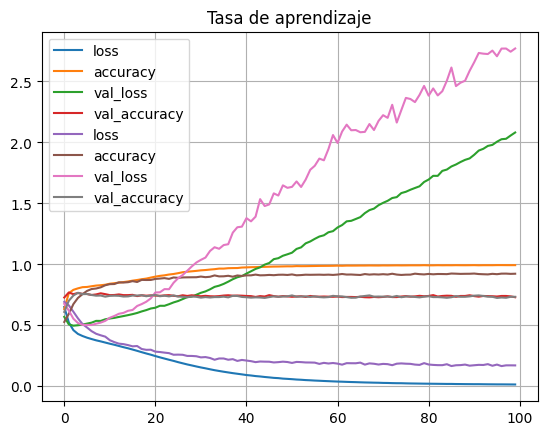

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
pd.DataFrame(history2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Utilizando capas Dropout se ve que realmente el accuracy de entrenamiento del modelo se reduce, pero en cambio el accuracy de validación se mantiene como en los modelos anteriores. También se puede observar que el error de validación crece de forma más rápida que el error del primer modelo.

**Ejercicio 1d - Evaluación de hiperparámetros mediante grid search**

In [8]:

# TO DO
learning_rate = [0.0001, 0.001, 0.01]
dropout = [0, 0.2, 0.5]
regularizer = [0.0001]
input_size = x_training[0].shape[0]

def grid_research(x_validation, y_validation, x_training, y_training, learning_rate, dropout, regularizer):
  model = Sequential()
  model.add(Dense(units=512, activation='relu', kernel_regularizer = regularizers.l2(regularizer), input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
  model.add(Dropout(dropout))
  model.add(Dense(units=256, activation = 'relu', kernel_regularizer = regularizers.l2(regularizer)))
  model.add(Dropout(dropout))
  model.add(Dense(units=128, activation = 'relu', kernel_regularizer = regularizers.l2(regularizer)))
  model.add(Dropout(dropout))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = learning_rate), metrics=['accuracy'])
  history2 = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation),  verbose=0)
  return history2




In [10]:
historial = pd.DataFrame(columns = ["learning_rate", "dropout", "regularizer", "best_epoch", "loss", "accuracy", "val_loss", "val_accuracy"])
i=0
for rate in learning_rate:
  for drop in dropout:
    for reg in regularizer:
      print(f"Parameters: learn_rate = {rate}, dropout = {drop}, regularizer = {reg}")
      hist = pd.DataFrame(grid_research(x_validation, y_validation, x_training, y_training, rate, drop, reg).history)
      best_epoch = hist.idxmax()["val_accuracy"]
      loss = hist.iloc[best_epoch]["loss"]
      accuracy = hist.iloc[best_epoch]["accuracy"]
      val_loss = hist.iloc[best_epoch]["val_loss"]
      val_accuracy = hist.iloc[best_epoch]["val_accuracy"]
      historial = pd.concat([historial, pd.DataFrame({"learning_rate": rate, "dropout": drop, "regularizer": reg, "best_epoch": best_epoch, "loss": loss, "accuracy": accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy}, index= [i])])
      i+=1


Parameters: learn_rate = 0.0001, dropout = 0, regularizer = 0.0001
Parameters: learn_rate = 0.0001, dropout = 0.2, regularizer = 0.0001
Parameters: learn_rate = 0.0001, dropout = 0.5, regularizer = 0.0001
Parameters: learn_rate = 0.001, dropout = 0, regularizer = 0.0001
Parameters: learn_rate = 0.001, dropout = 0.2, regularizer = 0.0001
Parameters: learn_rate = 0.001, dropout = 0.5, regularizer = 0.0001
Parameters: learn_rate = 0.01, dropout = 0, regularizer = 0.0001
Parameters: learn_rate = 0.01, dropout = 0.2, regularizer = 0.0001
Parameters: learn_rate = 0.01, dropout = 0.5, regularizer = 0.0001


In [11]:
historial

,learning_rate,dropout,regularizer,best_epoch,loss,accuracy,val_loss,val_accuracy
0,0.0001,0,0.0001,2,0.522718,0.820665,0.617304,0.761468
1,0.0001,0.2,0.0001,3,0.521812,0.809971,0.607859,0.770642
2,0.0001,0.5,0.0001,12,0.412482,0.861127,0.652832,0.776376
3,0.0010,0,0.0001,0,0.663694,0.684682,0.577144,0.766055
4,0.0010,0.2,0.0001,3,0.221905,0.944364,0.910553,0.756881
5,0.0010,0.5,0.0001,11,0.172299,0.972832,1.101179,0.774083
6,0.0100,0,0.0001,2,0.599980,0.789451,0.690612,0.738532
7,0.0100,0.2,0.0001,3,0.635571,0.808092,0.782778,0.759174
8,0.0100,0.5,0.0001,46,0.643176,0.862428,0.861791,0.753440


Observando los resultados de la tabla se podría concluir que el mejor conjunto de hiperparámetros sería

learning_rate: 0.0001    

dropout: 0.5

regularizer:      0.0001

Ya que es el que mejor val_accuracy obtiene. Aunque se podría argumentar que el mdelo con hiperparámetros

learning_rate: 0.001    

dropout: 0.5

regularizer:      0.0001

También podría considerarse como el mejor porque a cambio de un poco menos de val_Acc se consigue un accuracy del 97%

# ***Ejercicio 2 - LSTMs***

# Preprocesado de datos - Tokenization y sequence padding

In [13]:

# Creamos un tokenier que considera las 1000 palabras más frecuentes en el corpus
max_words = 10000
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)

# Construimos el índice (diccionario) de palabras a partir del conjunto de datos de entrenamiento
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index

# Obtenemos los textos como secuencias de enteros
trainining_sequences = tokenizer.texts_to_sequences(training_texts)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding: convertimos las secuencias de enteros a un tensor 2D de forma (numero_secuencias, longitud_secuencia)
# Con ello igualamos la longitud de las secuencias de entrada
max_seq = 40
x_traininig = preprocessing.sequence.pad_sequences(trainining_sequences, maxlen=max_seq)
x_vadidation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_seq)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq)

y_traininig = training_labels
y_validation = validation_labels
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_training.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_validation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

# Visualizamos un par de instancias de entrenamiento
print('\nTexto: {}\nVector padded: {}'.format(training_texts.iloc[0], x_training[0]))
print('\nTexto: {}\nVector padded: {}'.format(training_texts.iloc[1], x_training[1]))

Dimensiones del conjunto de entrenamiento: (6920, 1000)
Dimensiones del conjunto de validación: (872, 1000)
Dimensiones del conjunto de test: (1821, 40)

Texto: It is dark , brooding and slow , and takes its central idea way too seriously .
Vector padded: [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

# Construcción de la red

In [ ]:


embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))
# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1411713 (5.39 MB)
Trainable params: 1411713 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenamos la red durante 20 épocas y con batches de tamaño 128
history_lstm = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)

Epoch 1/20
55/55 [==============================] - 16s 218ms/step - loss: 0.6170 - accuracy: 0.6513 - val_loss: 0.5088 - val_accuracy: 0.7718
Epoch 2/20
55/55 [==============================] - 10s 180ms/step - loss: 0.3262 - accuracy: 0.8737 - val_loss: 0.4675 - val_accuracy: 0.7970
Epoch 3/20
55/55 [==============================] - 8s 152ms/step - loss: 0.1713 - accuracy: 0.9402 - val_loss: 0.5436 - val_accuracy: 0.7993
Epoch 4/20
55/55 [==============================] - 10s 178ms/step - loss: 0.0991 - accuracy: 0.9673 - val_loss: 0.7396 - val_accuracy: 0.7936
Epoch 5/20
55/55 [==============================] - 10s 184ms/step - loss: 0.0570 - accuracy: 0.9827 - val_loss: 0.7539 - val_accuracy: 0.7787
Epoch 6/20
55/55 [==============================] - 9s 158ms/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.8856 - val_accuracy: 0.7821
Epoch 7/20
55/55 [==============================] - 10s 178ms/step - loss: 0.0206 - accuracy: 0.9952 - val_loss: 1.0559 - val_accuracy: 0.7706
E

**Ejercicio 2a - LSTM de una capa**

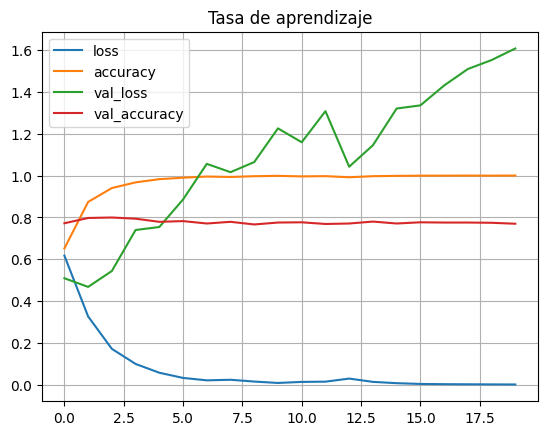

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history_lstm.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

De forma global en el modelo consigue unos resultados parecidos, pero se puede observar que en la época 4 se obtiene un 95% de accuracy y 0.8% de val_accuracy, mejorando los resultados conseguidos en las aproximaciones anteriores

**Ejercicio 2b - Early stopping**

In [14]:


embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))
# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))
callback = EarlyStopping(monitor='val_accuracy', min_delta=.05, mode="min" ,patience=5, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Exception ignored in: <function _xla_gc_callback at 0x7e03c22fc1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1411713 (5.39 MB)
Trainable params: 1411713 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Entrenamos la red durante 20 épocas y con batches de tamaño 128
history_lstm_stop = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, callbacks = [callback],validation_data=(x_vadidation, y_validation), verbose=1)

Epoch 1/20
55/55 [==============================] - 19s 250ms/step - loss: 0.6208 - accuracy: 0.6439 - val_loss: 0.4966 - val_accuracy: 0.7706
Epoch 2/20
55/55 [==============================] - 9s 171ms/step - loss: 0.3262 - accuracy: 0.8741 - val_loss: 0.4659 - val_accuracy: 0.7844
Epoch 3/20
55/55 [==============================] - 10s 187ms/step - loss: 0.1696 - accuracy: 0.9419 - val_loss: 0.5828 - val_accuracy: 0.7913
Epoch 4/20
55/55 [==============================] - 10s 182ms/step - loss: 0.1125 - accuracy: 0.9634 - val_loss: 0.6741 - val_accuracy: 0.7867
Epoch 5/20
55/55 [==============================] - 9s 159ms/step - loss: 0.0599 - accuracy: 0.9815 - val_loss: 0.8061 - val_accuracy: 0.7867
Epoch 6/20
55/55 [==============================] - 13s 235ms/step - loss: 0.0360 - accuracy: 0.9893 - val_loss: 0.8944 - val_accuracy: 0.7798


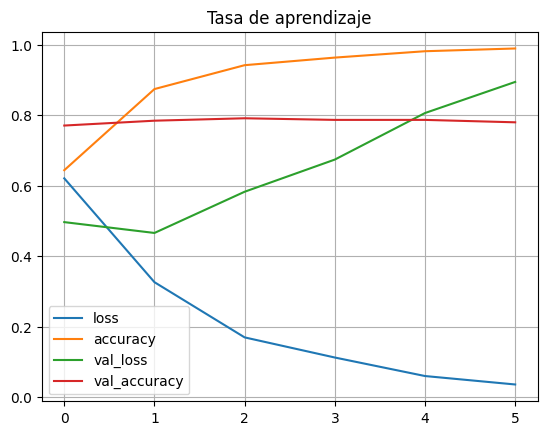

In [16]:
fig, ax = plt.subplots()
pd.DataFrame(history_lstm_stop.history).plot(ax = ax, use_index= False, xlabel = ["loss_h1", "accuracy_h1", "val_loss_h1", "val_accuracy_h1"])
plt.legend()
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Se puede ver que conseguimos más o menos los mismos resultados que con la LSTM normal y hacemos un número mucho menor de épocas de entrenamiento, reduciendo así el coste del mismo.

**Ejercicio 2c - Tamaño de embeddings y número de unidades LSTM**



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dense_46 (Dense)            (None, 1)                 129       
                                                                 
Total params: 738945 (2.82 MB)
Trainable params: 738945 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
55/55 [==============================] - 14s 170ms/step - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6882 - val_accuracy: 0.5183
Epoch 2/20
55/55 [==============================] - 11s 196ms/step - loss: 0.6518 - accuracy: 0.6327 - val_loss: 0.5827 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


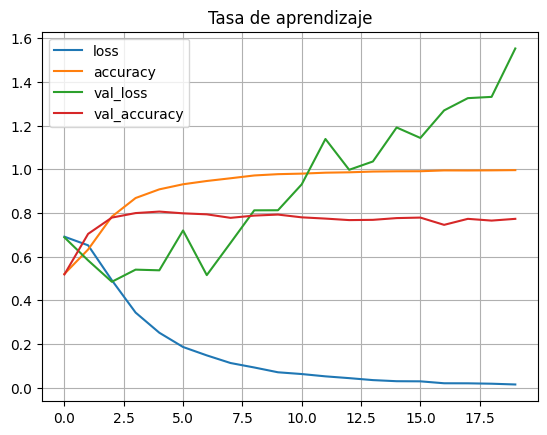

In [ ]:
embedding_size = 64
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_2 = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_emb_menor.h5")

fig, ax = plt.subplots()
pd.DataFrame(history_lstm_2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 256)         2560000   
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dense_47 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2757249 (10.52 MB)
Trainable params: 2757249 (10.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
55/55 [==============================] - 17s 229ms/step - loss: 0.6874 - accuracy: 0.5368 - val_loss: 0.6536 - val_accuracy: 0.6411
Epoch 2/20
55/55 [==============================] - 13s 231ms/step - loss: 0.5913 - accuracy: 0.7077 - val_loss: 0.5102 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


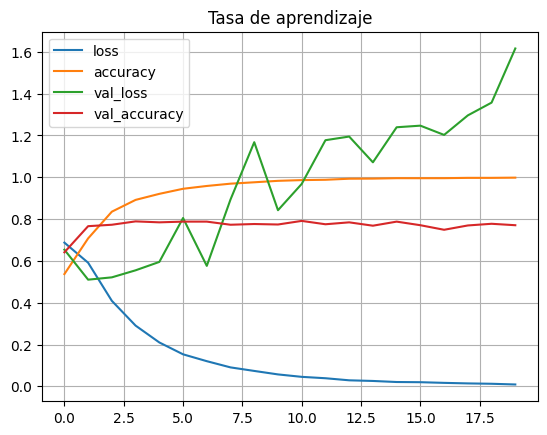

In [ ]:
embedding_size = 256
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_2 = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_emb_mayor.h5")

fig, ax = plt.subplots()
pd.DataFrame(history_lstm_2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         1280000   
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
55/55 [==============================] - 11s 125ms/step - loss: 0.6852 - accuracy: 0.5419 - val_loss: 0.6404 - val_accuracy: 0.6789
Epoch 2/20
55/55 [==============================] - 6s 109ms/step - loss: 0.5836 - accuracy: 0.7137 - val_loss: 0.5161 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


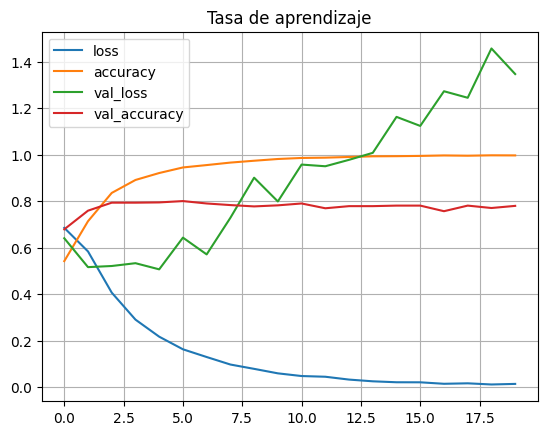

In [ ]:
embedding_size = 128
lstm_hidden_size = 64

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_2 = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_lstmsize_menor.h5")
fig, ax = plt.subplots()
pd.DataFrame(history_lstm_2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         1280000   
                                                                 
 lstm_11 (LSTM)              (None, 256)               394240    
                                                                 
 dense_49 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1674497 (6.39 MB)
Trainable params: 1674497 (6.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
55/55 [==============================] - 26s 394ms/step - loss: 0.6910 - accuracy: 0.5198 - val_loss: 0.6847 - val_accuracy: 0.5608
Epoch 2/20
55/55 [==============================] - 19s 352ms/step - loss: 0.6430 - accuracy: 0.6439 - val_loss: 0.5498 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


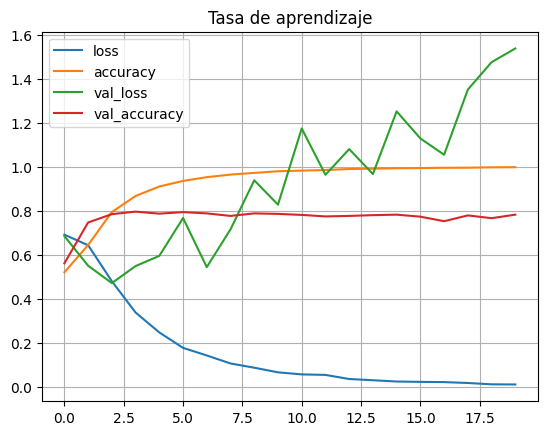

In [ ]:
embedding_size = 128
lstm_hidden_size = 256

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_2 = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_lstmsize_mayor.h5")

fig, ax = plt.subplots()
pd.DataFrame(history_lstm_2.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

El efecto más notable es que al subir el número de unidades LSTM o embedding lo hace también el tiempo de entrenamiento y se consiguen resultados parecidos para las redes, pero obviamente al bajar mucho los parámetros se volvería inútil la red por lo tanto habría que intentar encontrar el conjunto de parámetros que con un menor tiempo de entrenamiento se consigan resultados parecidos a las redes que son más costosas computacionalmente. Además como los resultados son los mismos se puede asumir que parte de las unidades de la red o del tamaño del embedding es irrelevante ya que no se mejora la performance del modelo.

# ***Ejercicio 3 - LSTMs avanzadas***

**Ejercicio 3a - Stacked LSTMs**

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 128)         1280000   
                                                                 
 lstm_28 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1461057 (5.57 MB)
Trainable params: 1461057 (5.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
55/55 [==============================] - 31s 408ms/step - loss: 0.6896 - accuracy: 0.5269 - val_loss: 0.6665 - val_accuracy: 0.6330
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


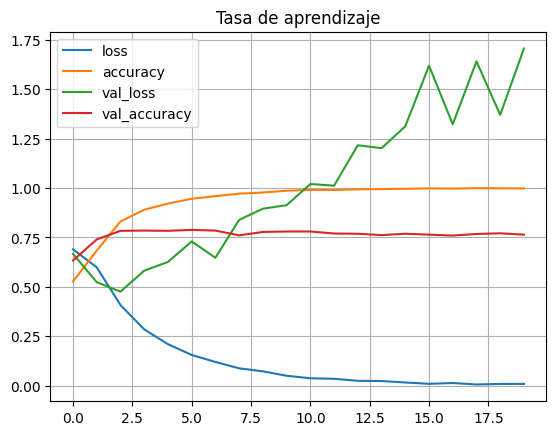

In [ ]:
embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))
# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size, return_sequences=True))
model.add(LSTM(int(lstm_hidden_size/2)))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_stacked = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_avanz.h5")

fig, ax = plt.subplots()
pd.DataFrame(history_lstm_stacked.history).plot(ax = ax, label = "History 2")
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Se ha creado una red de dos capas LSTM de 128 y 68 capas respectivamente, y se puede observar que hay un creciento más rápido del accuracy que con los ejemplos anteriores y por lo tanto que se está aprendiendo más rápido los datos del modelo incluso antes de sobreajustar por lo tanto se podría decir que tiene un mejor rendimiento.

**Ejercicio 3b - Bidirectional LSTMs**

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1543425 (5.89 MB)
Trainable params: 1543425 (5.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
55/55 [==============================] - 29s 367ms/step - loss: 0.6899 - accuracy: 0.5240 - val_loss: 0.6807 - val_accuracy: 0.6239
Epoch 2/10
55/55 [==============================] - 20s 361ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


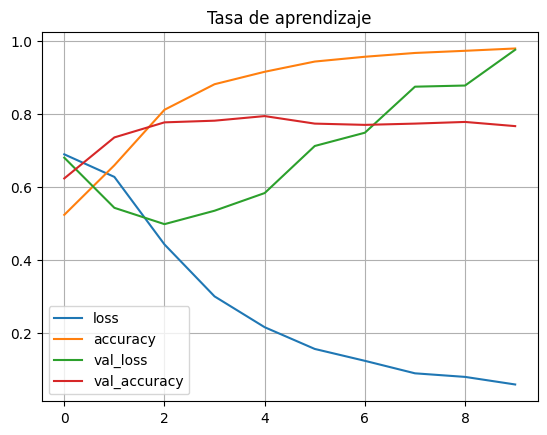

In [ ]:

embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

forward = LSTM(128)
#backward = LSTM(128, return_sequences=True, go_backwards = True)

model.add(Bidirectional(forward))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

history_lstm_bidirectional = model.fit(x_traininig, y_traininig, epochs=10, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_LSTM_bidir.h5")

fig, ax = plt.subplots()
pd.DataFrame(history_lstm_bidirectional.history).plot(ax = ax)
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()
# TO DO

El crecimiento del accuracy en esta red es parecida a la anterior, salvo que se puede observar que el val_Accuracy llega al 0.8 en su entrenamiento, igualando así nuestro mejor modelo hasta el momento, con un 0.8 en val_Acc y 0.91 en acc, solamente con una capa bidireccional

# **Ejercicio 4 - Embeddings pre-entrenados: Glove**

# Carga de los embeddings

In [ ]:
num_tokens = 10000# len(word_index) +2 # Para usar todo el vocabulario
embedding_dim = 50
hits = 0
misses = 0


embeddings_index = {}
with bz2.open(data_folder + 'glove.6B.50d.txt.bz2') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.decode("utf-8")] = coefs

#print(list(embeddings_index.values())[:10], list(embeddings_index.values())[0], type(list(embeddings_index.values())[0]))

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

 #Para corregir el índice al incluir la palabra
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and (i < num_tokens):
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else: #Si hay alguna palabra que no está en el embedding para no dejar ese hueco vacío entonces cogeremos la siguiente
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 9856 words (3983 misses)


Se ha cargado los embeddings de Glove y metido los embedding de las 10000 primeras palabras de nuestro índice de palabras creado anteriormente en una matriz que luego se utilizará como matriz de la capa Embedding() para las redes posteriores

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.21705   ,  0.46515   , -0.46757001, ..., -0.043782  ,
         0.41012999,  0.1796    ],
       ...,
       [-0.68794   , -1.10459995,  0.13926999, ..., -0.64500999,
         0.63125998, -0.602     ],
       [ 0.67970997, -0.51002997, -0.79079998, ...,  0.010981  ,
        -0.21667001,  0.32539001],
       [ 0.68246001,  1.14349997, -0.71842003, ..., -0.11896   ,
         0.18547   , -0.70108002]])

**Ejecicio 4a - Inicialización de la red con embeddings Glove**

In [ ]:
model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(input_dim = num_tokens , weights = [embedding_matrix] , mask_zero=True, output_dim = 50))
# Añadimos una capa LSTM
model.add(LSTM(128))
# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 50)          500000    
                                                                 
 lstm_6 (LSTM)               (None, 128)               91648     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 591777 (2.26 MB)
Trainable params: 91777 (358.50 KB)
Non-trainable params: 500000 (1.91 MB)
_________________________________________________________________


In [ ]:
history_lstm_embedding = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_Glove.h5")


Epoch 1/20
55/55 [==============================] - 14s 182ms/step - loss: 0.6407 - accuracy: 0.6254 - val_loss: 0.6031 - val_accuracy: 0.6938
Epoch 2/20
55/55 [==============================] - 7s 124ms/step - loss: 0.5791 - accuracy: 0.7036 - val_loss: 0.6185 - val_accuracy: 0.6697
Epoch 3/20
55/55 [==============================] - 8s 153ms/step - loss: 0.5502 - accuracy: 0.7181 - val_loss: 0.5954 - val_accuracy: 0.6835
Epoch 4/20
55/55 [==============================] - 7s 130ms/step - loss: 0.5396 - accuracy: 0.7262 - val_loss: 0.6869 - val_accuracy: 0.6491
Epoch 5/20
55/55 [==============================] - 8s 155ms/step - loss: 0.5216 - accuracy: 0.7408 - val_loss: 0.5296 - val_accuracy: 0.7362
Epoch 6/20
55/55 [==============================] - 7s 131ms/step - loss: 0.5116 - accuracy: 0.7408 - val_loss: 0.8056 - val_accuracy: 0.6193
Epoch 7/20
55/55 [==============================] - 8s 151ms/step - loss: 0.5075 - accuracy: 0.7532 - val_loss: 0.6020 - val_accuracy: 0.6766
Epoch

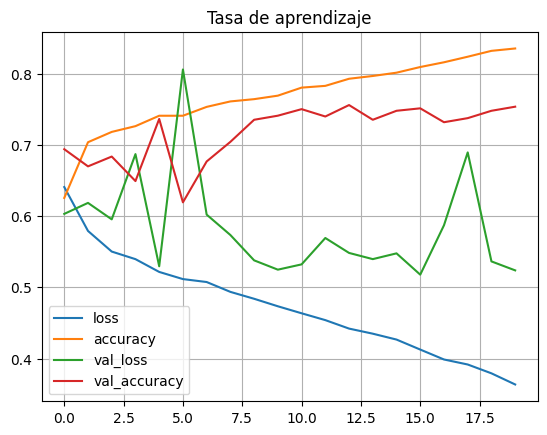

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history_lstm_embedding.history).plot(ax = ax)
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Con este conjunto de embeddings se puede ver que nuestro modelo ha conseguido resultados más pobres en comparación con los obtenidos en pruebas anteriores. Esto es porque la dimensión de nuestros embeddings es mucho menor, pasando de 128 que había en todas las redes anteriores a 50 en esta, pero sí que nos ahorramos el coste de entrenamiento de la capa de Embedding, ya que está preentrenada por los valores descargados. Los resultados obtenidos, aunque peroes respecto al accuracy, igualan la mayoría de los modelos generados si se tiene en cuenta el val_accuracy. Por lo tanto el modelo que se obtiene es bastante satisfactorio contando con el tiempo de entrenamiento ahorrado

**Ejercicio 4b - Evitando el overfitting**

In [ ]:
model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(num_tokens , weights = [embedding_matrix] , mask_zero=True, output_dim = 50))
# Añadimos una capa LSTM
model.add(Dropout(0.4))
model.add(LSTM(128))
# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          500000    
                                                                 
 dropout_2 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               91648     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 591777 (2.26 MB)
Trainable params: 91777 (358.50 KB)
Non-trainable params: 500000 (1.91 MB)
_________________________________________________________________


In [ ]:
history_lstm_emb_over = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_validation), verbose=1)
model.save("modelos_entrenados\modelo_Glove_sinOverfitting.h5")


Epoch 1/20
55/55 [==============================] - 16s 209ms/step - loss: 0.6528 - accuracy: 0.6139 - val_loss: 0.5692 - val_accuracy: 0.7144
Epoch 2/20
55/55 [==============================] - 7s 132ms/step - loss: 0.6103 - accuracy: 0.6697 - val_loss: 0.6525 - val_accuracy: 0.6342
Epoch 3/20
55/55 [==============================] - 9s 162ms/step - loss: 0.5913 - accuracy: 0.6902 - val_loss: 0.6497 - val_accuracy: 0.6170
Epoch 4/20
55/55 [==============================] - 7s 132ms/step - loss: 0.5912 - accuracy: 0.6870 - val_loss: 0.7019 - val_accuracy: 0.6158
Epoch 5/20
55/55 [==============================] - 9s 164ms/step - loss: 0.5732 - accuracy: 0.6958 - val_loss: 0.5360 - val_accuracy: 0.7408
Epoch 6/20
55/55 [==============================] - 8s 148ms/step - loss: 0.5699 - accuracy: 0.7052 - val_loss: 0.7532 - val_accuracy: 0.5757
Epoch 7/20
55/55 [==============================] - 8s 137ms/step - loss: 0.5641 - accuracy: 0.7065 - val_loss: 0.6318 - val_accuracy: 0.6525
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


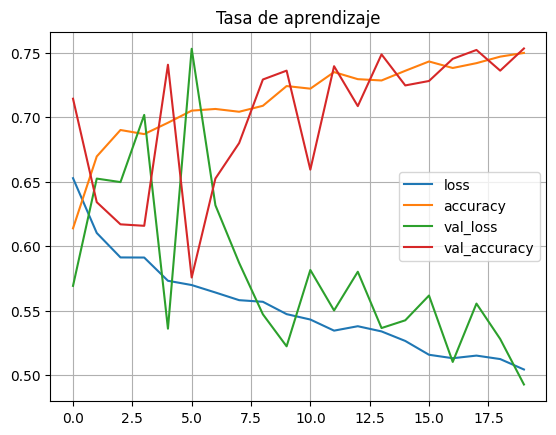

In [ ]:
fig, ax = plt.subplots()
pd.DataFrame(history_lstm_emb_over.history).plot(ax = ax)
plt.grid(True)
plt.gca() # set the vertical range to [0-1]
plt.title("Tasa de aprendizaje")
plt.show()

Utilizando una capa Dropout en la red se puede ver que el comportamiento del val_Accuracy es bastante dispar, ya que tiene varios picos al principio que, a lo largo del enternamiento sigue la tendencia del accuracy de entrenamiento. Este ha sido el único modelo que ha conseguido un accuracy final igual al vall_accuracy, por lo tanto podría darse el caso de que al seguir entrenando el modelo con un número mayor de épocas se obtuviesen aun mejores resultados. También como es el modelo que acaba con un val_acc igual al accuracy se podría entender como que este modelo no está sobreajustando, está aprendiendo a hacer bien la tarea para cualquier conjunto de datos (suponiendo que no haya sesgos en los datos de entrenamiento y validación)